In [25]:
#basic imports 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import datasets
import transformers
from tqdm import tqdm
import warnings 
warnings.filterwarnings('ignore')
device = torch.device("cuda")
from sklearn.metrics import f1_score,accuracy_score

### Load dataset

In [26]:
from datasets import load_dataset
text = load_dataset("csv",data_files="/kaggle/input/ai-vs-human/AI_vs_Human_essays100k.csv")

In [27]:
text = text.remove_columns('Unnamed: 0')

In [28]:
text = text['train'].train_test_split(train_size=0.8) 

In [29]:
text

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 78712
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 19678
    })
})

In [30]:
#explore dataset
text.set_format("pd")

In [31]:
df = text['train'][:]

In [32]:
df.head()

,text,label
0,"Dear principal,\n\nI think it's not fair to st...",0
1,Driverless cars are quite a new invention. The...,0
2,The new technology called Facial Action Coding...,0
3,Gun control is a really important issue that a...,1
4,Venus IA indeed a very powerful planet that ca...,0


Text(0.5, 1.0, 'Lable Count')

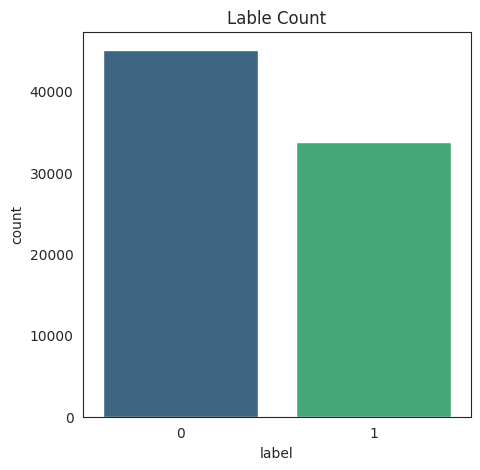

In [33]:
plt.figure(figsize=(5,5))
sns.set_style('white')
sns.countplot(x='label',data=df,palette='viridis')
plt.title('Lable Count')

In [34]:
df['wrd_len'] = df['text'].str.split().apply(len)

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78712 entries, 0 to 78711
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   text     78712 non-null  object
 1   label    78712 non-null  int64 
 2   wrd_len  78712 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.8+ MB


In [36]:
#load tokenizer and model
from transformers import AutoTokenizer
model_path = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_path)

In [37]:
out = tokenizer('this is sample text')
print(tokenizer.convert_ids_to_tokens(out.input_ids))

['[CLS]', 'this', 'is', 'sample', 'text', '[SEP]']


### tokenize dataset

### Reset format

In [38]:
text.reset_format()

In [39]:
def apply_tokenizer(batch):
    return tokenizer(batch['text'],padding=True,truncation=True)

In [40]:
text = text.map(apply_tokenizer,batch_size=None,batched=True)

Map:   0%|          | 0/78712 [00:00<?, ? examples/s]

Map:   0%|          | 0/19678 [00:00<?, ? examples/s]

### set to pytorch format

In [41]:
text.set_format("pt",columns=['input_ids','attention_mask','label'])

In [42]:
text['train'][0]

{'label': tensor(0),
 'input_ids': tensor([  101,  6203,  4054,  1010,  1045,  2228,  2009,  1005,  1055,  2025,
          4189,  2000,  2493,  2008,  2123,  1005,  1056,  2215,  2000,  2079,
          2451,  2326,  2323,  2022,  3140,  2205,  1012,  2009,  2323,  2022,
          1037,  3601,  2025,  2242,  2057,  2031,  2000,  2079,  1012,  2070,
          2493,  2066,  5094,  2041,  1998,  2108,  2785,  2500,  2079,  2025,
          2215,  2000,  5949,  2037,  2051,  5094,  2030,  2022,  3625,  2008,
          2003,  2006,  2068,  2025,  2006,  2017,  1012,  2009,  2052,  2022,
          2367,  2065,  1996,  2493,  2020,  2437,  1037,  6752,  1998, 11669,
          2075,  1996,  2082,  2006,  3800,  2059,  2027,  2323,  2079,  2451,
          2326,  1010,  2021,  2070,  4268,  2024,  5697,  2030,  2079,  2025,
          2031,  1996,  2051,  2000,  2393,  2041,  1012,  2070,  4268,  2079,
          2009,  2138,  2027,  2031,  2498,  2488,  2000,  2079,  1012,  1045,
          1005,  1

### Load model

In [43]:
from transformers import AutoModelForSequenceClassification
num_labels = 2
model = (AutoModelForSequenceClassification.from_pretrained(model_path,num_labels=num_labels).to(device))

In [44]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels,preds)
    acc = accuracy_score(labels,preds)
    return {'f1':f1,'acc':acc}

### training hypyer params

In [45]:
from transformers import TrainingArguments
model_name = 'RoBERTa_AI_text_detection'
batch_size = 32
learning_rate = 2e-6
loggin_steps = len(text['train'])//batch_size
weigth_decay = 0.025
training_args = TrainingArguments(output_dir=model_name,
                                 per_device_eval_batch_size=batch_size,
                                 per_device_train_batch_size=batch_size,
                                 logging_steps=loggin_steps,
                                 log_level="error",
                                 evaluation_strategy="epoch",
                                 learning_rate=learning_rate,
                                 num_train_epochs=2,
                                 weight_decay=weigth_decay,
                                 disable_tqdm=False,
                                 push_to_hub=True)

### trainer

In [46]:
from transformers import Trainer

In [47]:
trainer = Trainer(model=model,
                 args = training_args,
                 compute_metrics=compute_metrics,
                 train_dataset=text['train'],
                 eval_dataset=text['test'],
                 tokenizer = tokenizer)

In [48]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss,F1,Acc
1,0.092200,0.053058,0.982742,0.985059
2,0.029700,0.052640,0.984375,0.986482


TrainOutput(global_step=4920, training_loss=0.060937496603038765, metrics={'train_runtime': 4792.9788, 'train_samples_per_second': 32.845, 'train_steps_per_second': 1.027, 'total_flos': 2.0853547766022144e+16, 'train_loss': 0.060937496603038765, 'epoch': 2.0})

In [49]:
trainer.push_to_hub(commit_message='Done!')

events.out.tfevents.1732883532.d6dccfbb0153.30.0:   0%|          | 0.00/6.36k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/Sharpaxis/RoBERTa_AI_text_detection/commit/03c45c10c1f339f3935691931c3523fcb181fa24', commit_message='Done!', commit_description='', oid='03c45c10c1f339f3935691931c3523fcb181fa24', pr_url=None, repo_url=RepoUrl('https://huggingface.co/Sharpaxis/RoBERTa_AI_text_detection', endpoint='https://huggingface.co', repo_type='model', repo_id='Sharpaxis/RoBERTa_AI_text_detection'), pr_revision=None, pr_num=None)

In [50]:
# Use a pipeline as a high-level helper
from transformers import pipeline

pipe = pipeline("text-classification", model="Sharpaxis/RoBERTa_AI_text_detection")

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [51]:
pipe("Artificial Intelligence represents a transformative technological advancement that has significantly impacted various aspects of modern society. The implementation of machine learning algorithms and neural networks has enabled systems to process vast quantities of data and perform complex pattern recognition tasks with increasing accuracy. Common applications include recommendation systems, facial recognition technology, and natural language processing. While the integration of AI into daily life has proceeded rapidly, considerations regarding its societal implications and ethical deployment remain paramount. The continued evolution of AI capabilities suggests an increasingly automated future across multiple sectors.")

[{'label': 'LABEL_1', 'score': 0.9984328150749207}]

In [52]:
def check_if_ai(text):
    if type(text) != str:
        text = str(text)
    out = pipe(text)[0]
    if out['label'] == 'LABEL_1':
        print(f"MODEL PREDICTION: ")
        print(f"AI GENERATED || SCORE : {out['score']:.4f}")
    else:
        print(f"MODEL PREDICTION: ")
        print(f"HUMAN GENERATED || SCORE : {out['score']:.4f}")

In [53]:
check_if_ai("Artificial Intelligence represents a transformative technological advancement that has significantly impacted various aspects of modern society. The implementation of machine learning algorithms and neural networks has enabled systems to process vast quantities of data and perform complex pattern recognition tasks with increasing accuracy. Common applications include recommendation systems, facial recognition technology, and natural language processing. While the integration of AI into daily life has proceeded rapidly, considerations regarding its societal implications and ethical deployment remain paramount. The continued evolution of AI capabilities suggests an increasingly automated future across multiple sectors.")

MODEL PREDICTION: 
AI GENERATED || SCORE : 0.9984


In [54]:
check_if_ai("You know what's crazy about AI? The other day I was trying to explain it to my mom, and I caught myself rambling about neural networks and deep learning - totally lost her after 30 seconds. But then I thought about how we actually use AI every day. Like when Netflix somehow knows I want to watch another cooking show after binging Chef's Table, or when my phone recognizes my face even with my morning bedhead. It's everywhere, but we barely notice it anymore. Kind of wild how quickly something so sci-fi became just... normal life, right? Sometimes I wonder if we're moving too fast with all this, but then again, that's probably what people said about electricity too")

MODEL PREDICTION: 
AI GENERATED || SCORE : 0.9974


In [55]:
check_if_ai("""Shakespeare's plays portray recognisable people in situations that we can all relate to - including love, marriage, death, mourning, guilt, the need to make difficult choices, separation, reunion and reconciliation. They do so with great humanity, tolerance, and wisdom. They help us to understand what it is to be human, and to cope with the problems of being so.  """)

MODEL PREDICTION: 
AI GENERATED || SCORE : 0.9971


In [56]:
y_val = trainer.predict(text['test'])

In [57]:
preds = np.argmax(y_val.predictions,axis=1)

In [58]:
labels = np.array(text['test']['label'])

In [59]:
from sklearn.metrics import classification_report
print(classification_report(labels,preds))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     11266
           1       0.97      1.00      0.98      8412

    accuracy                           0.99     19678
   macro avg       0.98      0.99      0.99     19678
weighted avg       0.99      0.99      0.99     19678

